In [1]:
import dynamiqs as dq
import jax.numpy as jnp
import qutip as qt
import matplotlib.pyplot as plt
import jax.lax as lax
import seaborn as sns
import pandas as pd
import numpy as np
from jax import config
config.update("jax_enable_x64", True)

In [2]:
## Spin parameters
h    = 6.6260693e-34       # J.s
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.2355695           # g nuclear 183W (INDC International Nuclear Data Committee)
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T
tau = 2*np.pi           # two pi

# Magnetic field
B0 = 0.447 # T
theta = 0*np.pi/180 # rad
phi = 0*np.pi/180 # rad
B_field = np.array([B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)])

# omega_L = 2*np.pi*mu_I/h*1e-6*B0 # rad/us
omega_L = 790.40/1000*2*np.pi

# Hyperfine constants
A = tau * 1e-3 * (-35.2)
B = tau * 1e-3 * 70.4

In [3]:
S = 1/2
nS = int(2*S+1)
Si = qt.qeye(nS)

I = 1/2
nI = int(2*I+1)
Ii = qt.qeye(nI)

Sx, Sy, Sz = qt.jmat(S)
Sp, Sm = qt.spin_Jp(S), qt.spin_Jm(S)

SxI, SyI, SzI = (qt.tensor(op, Ii) for op in (Sx,Sy,Sz))
SpI, SmI = (qt.tensor(op, Ii) for op in (Sp,Sm))

Ix, Iy, Iz = qt.jmat(I)
Ip, Im = qt.spin_Jp(I), qt.spin_Jm(I)

IIx, IIy, IIz = (qt.tensor(Si, op) for op in (Ix,Iy,Iz))
IIp, IIm = (qt.tensor(Si, op) for op in (Ip,Im))

H_NZ = qt.tensor(Si, omega_L*Iz)

H_DD = A*qt.tensor(Sz,Iz) + B*qt.tensor(Sz, Ix)

H0 = H_NZ + H_DD

In [4]:
K00 = H0.eigenstates()[1][0]
K10 = H0.eigenstates()[1][1]
K01 = H0.eigenstates()[1][3]
K11 = H0.eigenstates()[1][2]

In [5]:
jH0 = jnp.array(H0.full())

jK00, jK10, jK01, jK11 = (jnp.array(ket.full()) for ket in (K00, K10, K01, K11))

jSxI, jSyI, jSzI, jSpI, jSmI = (jnp.array(op.full()) for op in (SxI, SyI, SzI, SpI, SmI))

jIIx, jIIy, jIIz, jIIp, jIIm = (jnp.array(op.full()) for op in (IIx, IIy, IIz, IIp, IIm))

In [6]:
batch_n = 1000
detuning = A/2*jnp.linspace(49, 40, batch_n)

timesteps = 5000
pulse_duration = 400

args = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.5,
    'phase': 0,
}

def square_pulse(t, pulse_duration = 0, amplitude = 0, t0 = 0):
    return jnp.where((t >= t0) & (t < (t0 + pulse_duration)), amplitude/2, 0)

def square_pulse_p(t, detuning, phase = 0, **args):
  return square_pulse(t, **args) * jnp.exp(+1j*(t*jnp.expand_dims(detuning, (-1, -2))+phase))

def square_pulse_m(t, detuning, phase = 0, **args):
  return square_pulse(t, **args) * jnp.exp(-1j*(t*jnp.expand_dims(detuning, (-1, -2))+phase))

def H_args(t, detuning, **args):
  return jH0 + square_pulse_p(t, detuning, **args)*jSpI + square_pulse_m(t, detuning, **args)*jSmI

Ht = lambda t, detuning: H_args(t, detuning, **args)

H = dq.timecallable(Ht, args=(detuning,))
psi = jK00
tsave = jnp.linspace(0, pulse_duration, timesteps)

rabi_results = dq.sesolve(H, psi, tsave, exp_ops=[jSpI@jSmI])

In [14]:
rabi = lax.real(rabi_results.expects).reshape(batch_n, -1)
max_rabi_det = rabi.max(axis=1).reshape(-1).argmax()
max_rabi_t = rabi[max_rabi_det].argmax()

cut_rabi = rabi[:, max_rabi_t]
detuning[max_rabi_det]/tau*1e3+A/2*1e3/tau

Array(-804.84314, dtype=float32)

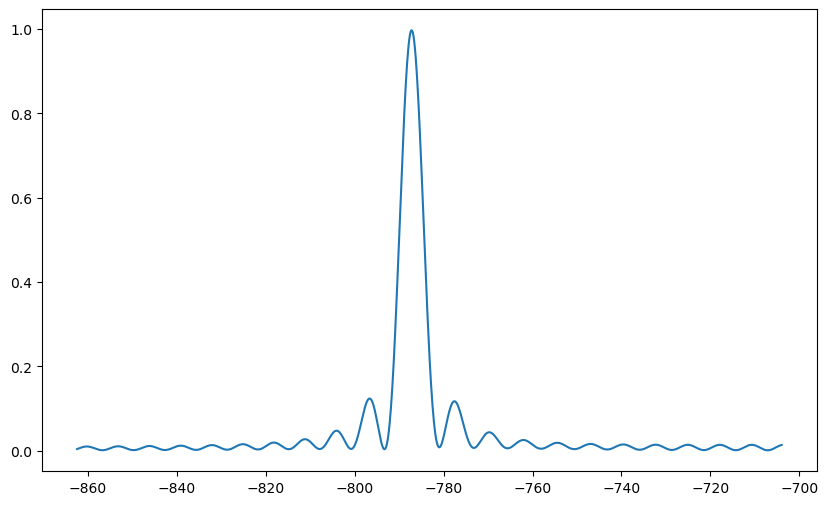

In [15]:
x = detuning * 1e3 / tau
y = cut_rabi

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(x, y, label="Electron spin state")

In [12]:
batch_n = 500
pulse_duration = 2000
timesteps = pulse_duration//5

# coupling_detuning =
raman_detuning = 1.4*tau
detuning = 13.877717976716323 + 1e-4*tau*np.linspace(-5, 5, batch_n)


arg1 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.8,
    'phase': 0
}

arg2 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.5,
    'phase': 0,
    'detuning': raman_detuning
}

def square_pulse(t, pulse_duration = 0, amplitude = 0, t0 = 0):
    return jnp.where((t >= t0) & (t < (t0 + pulse_duration)), amplitude/2, 0)

def square_pulse_p(t, detuning=0, phase = 0, **args):
  return square_pulse(t, **args) * jnp.exp(+1j*(t*jnp.expand_dims(detuning, (-1, -2))+phase))

def square_pulse_m(t, detuning=0, phase = 0, **args):
  return square_pulse(t, **args) * jnp.exp(-1j*(t*jnp.expand_dims(detuning, (-1, -2))+phase))

def H_args(t, detuning, arg1, arg2):
  return jH0 + square_pulse_p(t, detuning=detuning, **arg1)*jSpI + square_pulse_m(t, detuning=detuning, **arg1)*jSmI + square_pulse_p(t, **arg2)*jSpI + square_pulse_m(t, **arg2)*jSmI

Ht = lambda t, detuning: H_args(t, detuning, arg1, arg2)

psi = jK00
tsave = jnp.linspace(0, pulse_duration, timesteps)
solver=dq.solver.Tsit5(max_steps=1_000_000_000, atol=1e-8)
H = dq.timecallable(Ht, args=(detuning,))
raman_results = dq.sesolve(H, psi, tsave, exp_ops=[jSpI@jSmI, jIIp@jIIm], solver=solver)

In [13]:
raman_sz = lax.real(raman_results.expects[:,0,:])
raman_iz = lax.real(raman_results.expects[:,1,:])

<Axes: >

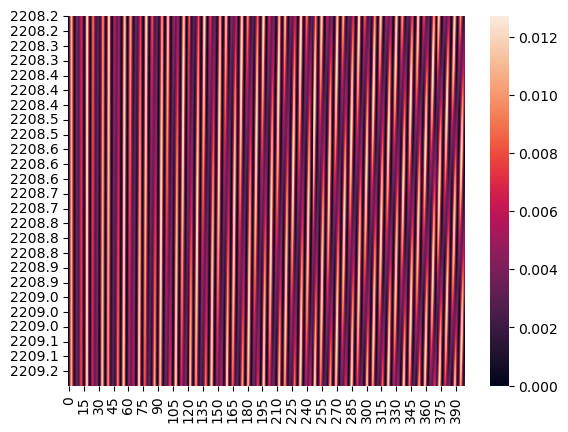

In [14]:
raman_sz_df = pd.DataFrame(raman_sz, index=detuning*1e3/tau)
raman_sz_df.index = raman_sz_df.index.map(lambda x: f'{x:.1f}')
sns.heatmap(raman_sz_df)

<Axes: >

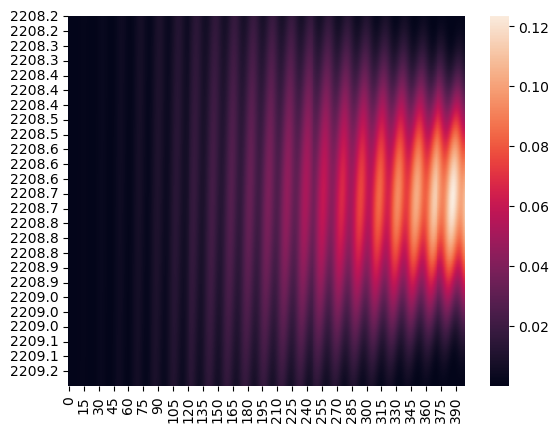

In [15]:
raman_iz_df = pd.DataFrame(raman_iz, index=detuning*1e3/tau)
raman_iz_df.index = raman_iz_df.index.map(lambda x: f'{x:.1f}')
sns.heatmap(raman_iz_df)

In [10]:
raman = lax.real(raman_results.expects).reshape(batch_n, -1)
max_raman_det = raman.max(axis=1).reshape(-1).argmax()
detuning[max_raman_det]

13.877717976716323

In [10]:
batch_n = 500
pulse_duration = 2000
timesteps = pulse_duration//5

# coupling_detuning =
raman_detuning = 1.4*tau
detuning = 0.8*tau+raman_detuning + 1e-3*tau*np.linspace(-5, 15, batch_n)


arg1 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.8,
    'phase': 0,
    'detuning': 13.877717976716323
}

arg2 = {
    't0': 0,
    'pulse_duration': pulse_duration,
    'amplitude': 0.5,
    'phase': 0,
    'detuning': raman_detuning
}

def square_pulse(t, pulse_duration = 0, amplitude = 0, t0 = 0):
    return jnp.where((t >= t0) & (t < (t0 + pulse_duration)), amplitude/2, 0)

def square_pulse_p(t, detuning=0, phase = 0, **args):
  return square_pulse(t, **args) * jnp.exp(+1j*(t*detuning+phase))

def square_pulse_m(t, detuning=0, phase = 0, **args):
  return square_pulse(t, **args) * jnp.exp(-1j*(t*detuning+phase))

def H_args(t, arg1, arg2):
  return jH0+square_pulse_p(t, **arg1)*jSpI + square_pulse_m(t, **arg1)*jSmI + square_pulse_p(t, **arg2)*jSpI + square_pulse_m(t, **arg2)*jSmI

Ht = lambda t: H_args(t, arg1, arg2)

psi = jK00
tsave = jnp.linspace(0, pulse_duration, timesteps)
solver=dq.solver.Tsit5(max_steps=1_000_000_000, atol=1e-8)
H = dq.timecallable(Ht)

raman_results  = dq.sesolve(H, psi, tsave, exp_ops=[jSpI@jSmI, jIIp@jIIm], solver=solver)

In [11]:
raman_results.infos.nsteps

Array(45277, dtype=int64, weak_type=True)

/opt/homebrew/anaconda3/envs/dynamiqs-jax/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


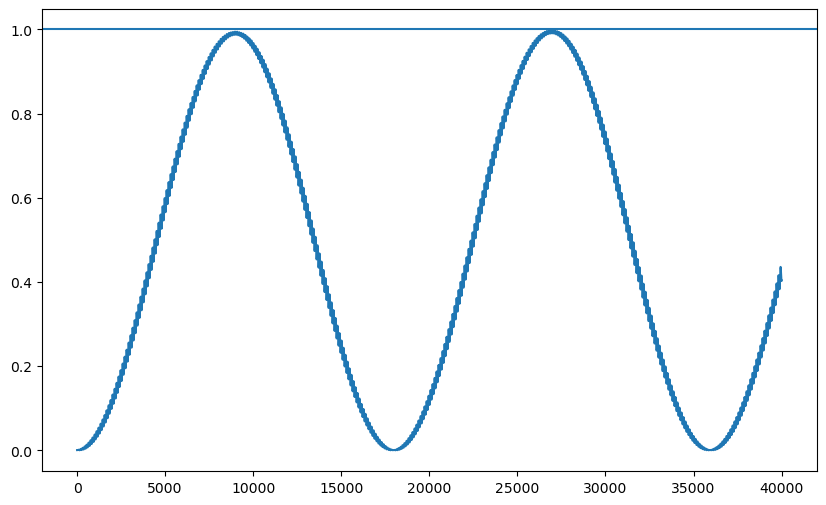

In [9]:
x = tsave
y = raman_results.expects[1]

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(x, y, label="Nuclei spin state")
axes.axhline(1)

In [64]:
jnp.append(jnp.array(raman_results[0].expects),jnp.array(raman_results[0].expects), axis=1).shape

(2, 2000)

In [57]:
raman_results.expects

FrozenInstanceError: cannot assign to field 'expects'

In [52]:
import jax
jax.device_count()

1